In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

Read cleaned data

In [2]:
df = pd.read_csv('clean_data.csv', index_col = [0])
df_clean = df.copy(deep = True)

Find size of categorical data

In [3]:
obj = df.select_dtypes('object').columns
for col in obj:
    unique = df[col].nunique()
    print(f'{col} : {unique}')

make : 44
body type : 21
transmission : 15
drivetrain : 3
fuel : 7
name : 898


Inital pairplot of all numerical data with price as the target variable 

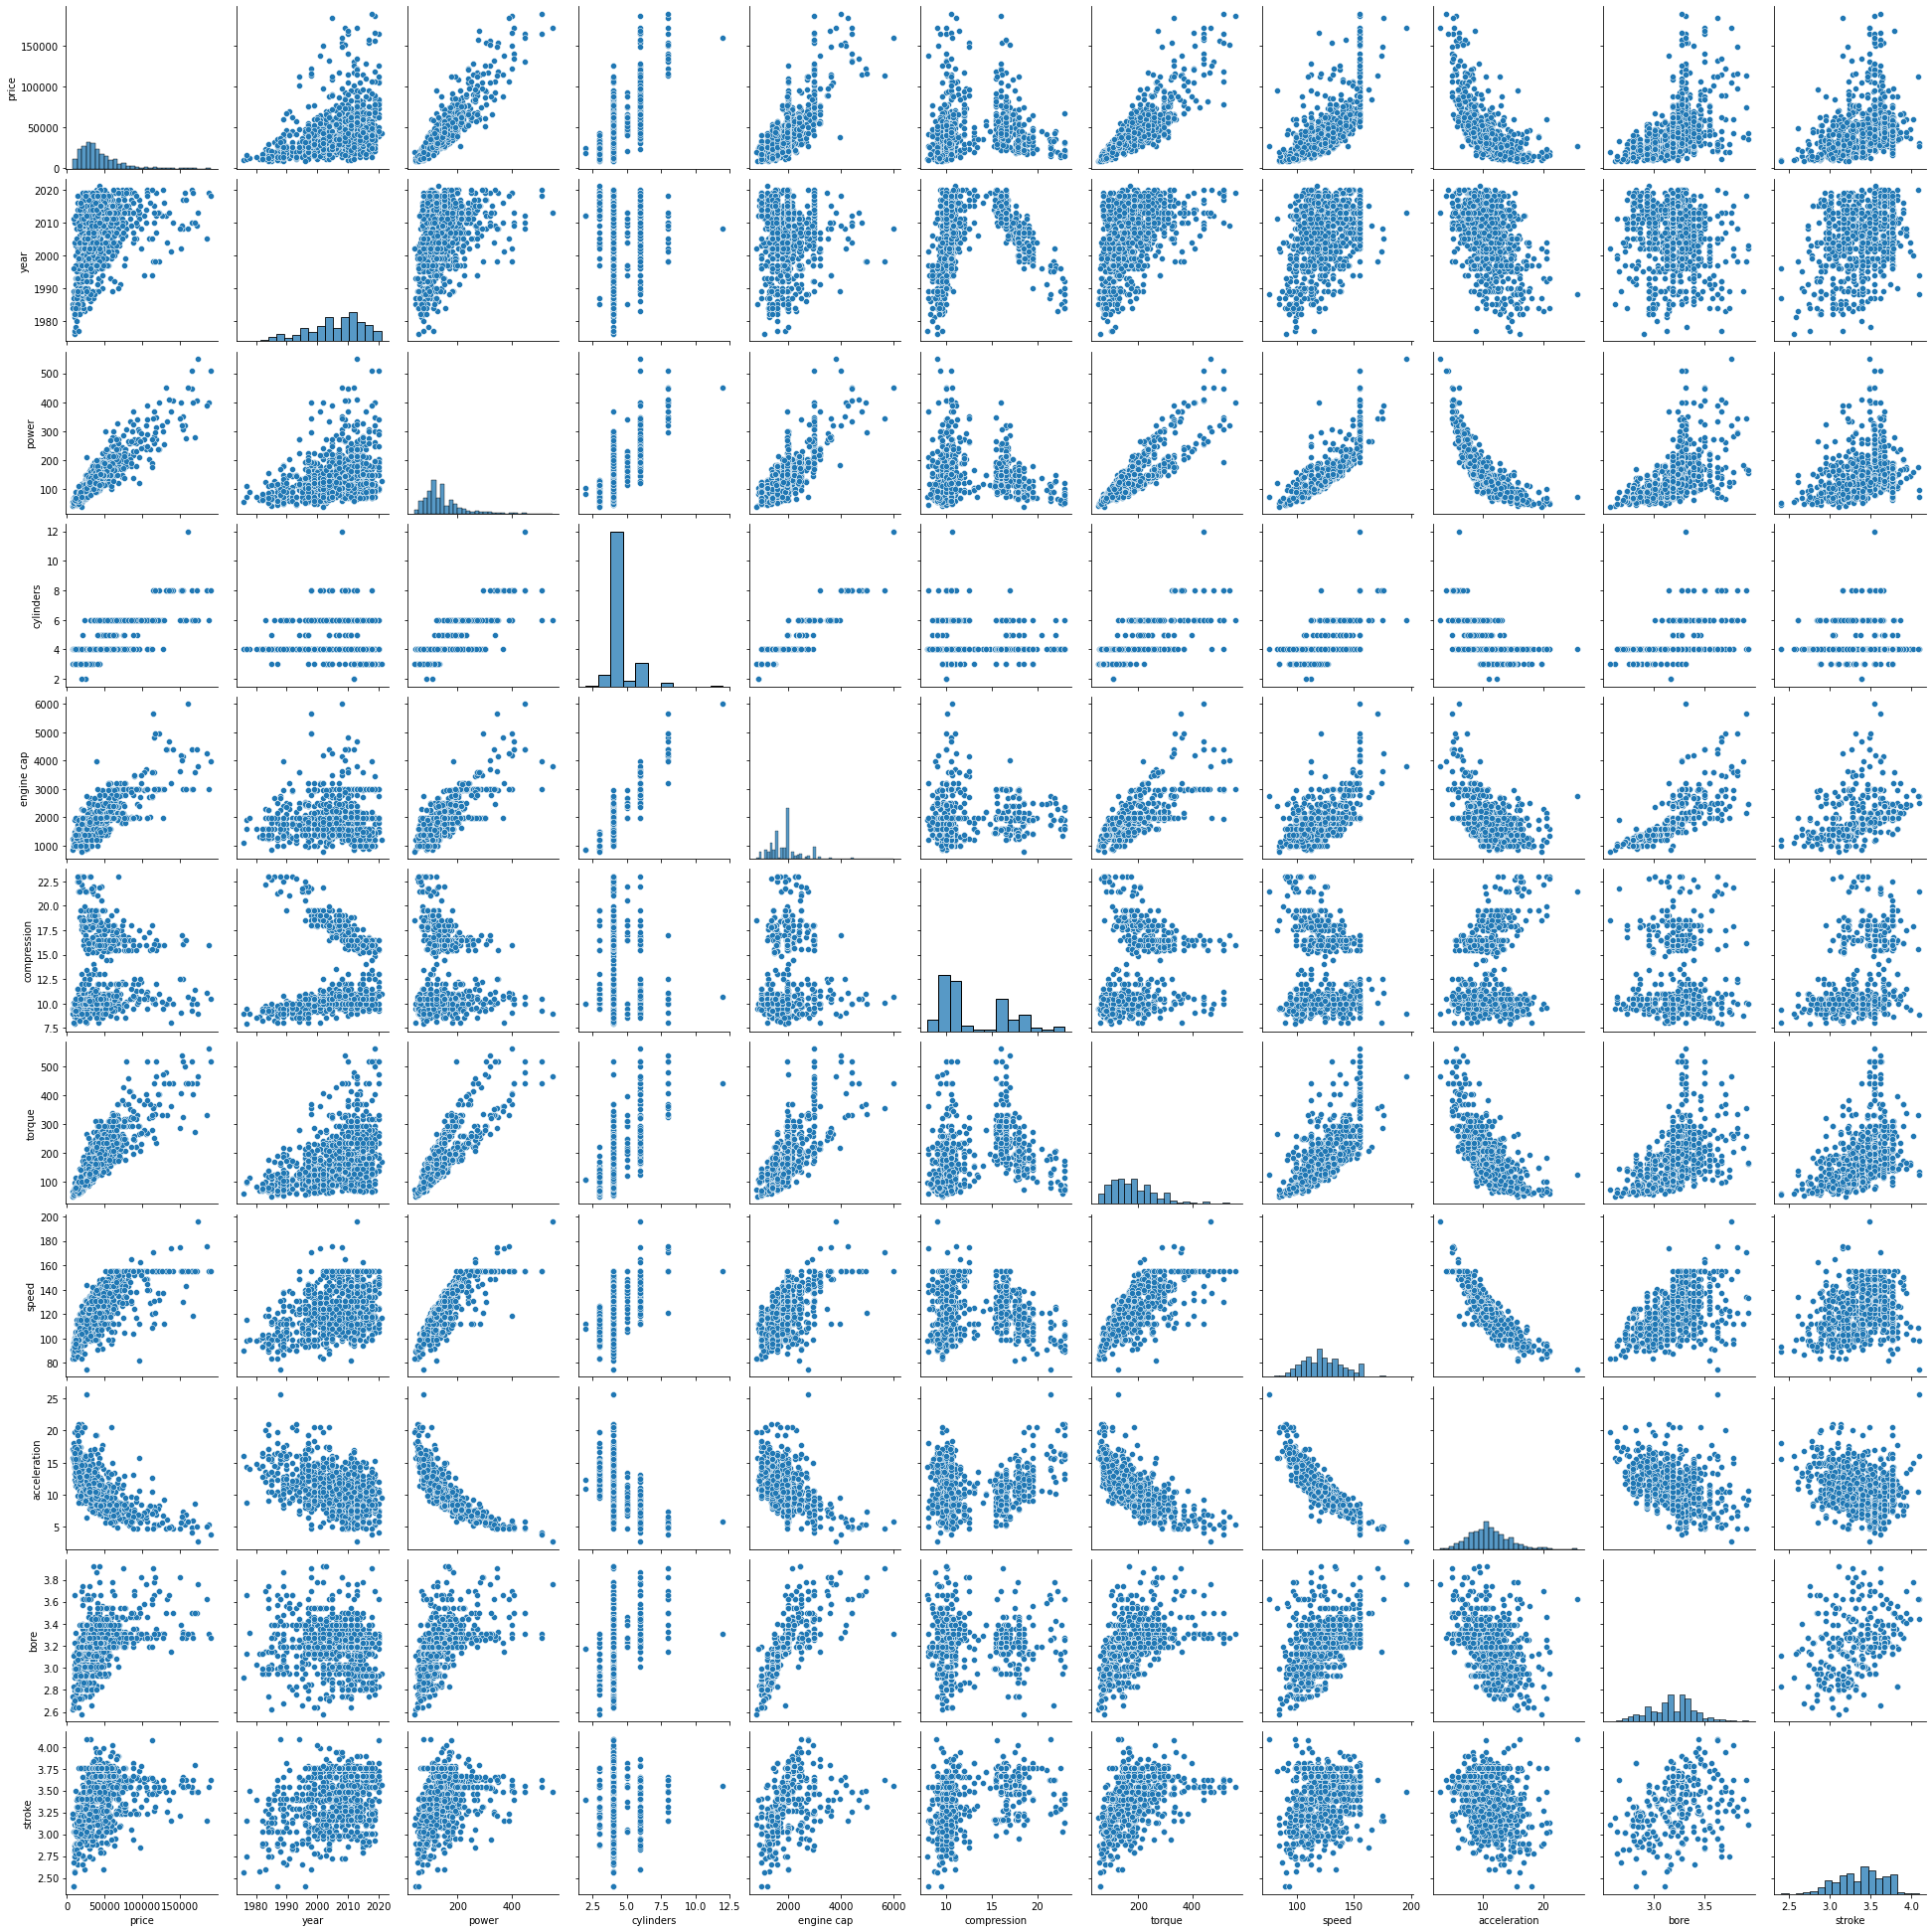

In [4]:
sns.pairplot(df)

Correlation heat map of all numerical data.

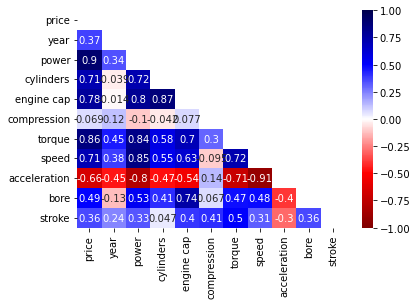

In [5]:
upper = np.triu(df.corr())  # optionally, you can just look at the lower triangle
sns.heatmap(df.corr(), cmap="seismic_r", annot=True, vmin=-1, vmax=1, mask=upper);
plt.savefig('full_heat_map.png')

Power is the most linearly correlated with the target variable, price. Remove columns that are multicollinear with power.

In [6]:
df = df.drop(['name'], axis=1)

In [7]:
# df = df.drop(['cylinders', 'acceleration', 'engine cap', 'torque', 'speed','name'], axis=1)

In [8]:
# upper = np.triu(df.corr())  # optionally, you can just look at the lower triangle
# sns.heatmap(df.corr(), cmap="seismic_r", annot=True, vmin=-1, vmax=1, mask=upper);
# plt.savefig('paired_heat_map.png')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 898 entries, 0 to 897
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         898 non-null    int64  
 1   make          898 non-null    object 
 2   year          898 non-null    int64  
 3   body type     898 non-null    object 
 4   transmission  898 non-null    object 
 5   drivetrain    898 non-null    object 
 6   fuel          898 non-null    object 
 7   power         898 non-null    int64  
 8   cylinders     898 non-null    int64  
 9   engine cap    898 non-null    int64  
 10  compression   898 non-null    float64
 11  torque        898 non-null    float64
 12  speed         898 non-null    int64  
 13  acceleration  898 non-null    float64
 14  bore          898 non-null    float64
 15  stroke        898 non-null    float64
dtypes: float64(5), int64(6), object(5)
memory usage: 151.6+ KB


Create dummy variables with all categorical data

In [10]:
df = pd.get_dummies(df, columns=['drivetrain','make','body type', 'transmission','fuel'], drop_first=True)
df.head()

,price,year,power,cylinders,engine cap,compression,torque,speed,acceleration,bore,...,transmission_7 speed automatic with double clutch,transmission_8 speed automatic,transmission_9 speed automatic,transmission_traploze automatic,fuel_bio ethanol / gasoline,fuel_diesel,fuel_gasoline,fuel_lpg / gasoline,fuel_natural gas,fuel_natural gas / gasoline
0,40540,2006,105,4,1896,19.0,184.37,116,11.1,3.13,...,0,0,0,0,0,1,0,0,0,0
1,39651,2005,150,4,1984,11.5,147.49,130,9.5,3.25,...,0,0,0,0,0,0,1,0,0,0
2,43395,2004,200,4,1984,10.5,206.49,146,6.9,3.25,...,0,0,0,0,0,0,1,0,0,0
3,35486,2010,105,4,1197,10.0,129.06,117,12.2,2.80,...,0,0,0,0,0,0,1,0,0,0
4,31483,1999,150,4,1781,9.5,154.87,135,8.2,3.19,...,0,0,0,0,0,0,1,0,0,0


Parse data into target variable and feature data

In [11]:
X, y = df.drop('price',axis=1), df['price']

Split data into train, test, and validation sets

In [12]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=2)

# Baseline Linear Regression

Function to calculate adjusted $R^2$

In [14]:
def R_adjusted(r2, n, k):
    return 1- ((1-r2)*(n-1))/(n-k-1)

This function calculates the mean absolute error of the target variables.

In [15]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

This linear regression includes all categorical data and calculated the MAE, $R^2_{train}$, $R^2_{val}$ & $R^2_{adjusted}$

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

val_set_pred = lr.predict(X_val)
r2 = lr.score(X_val, y_val)
n = len(y_val)
k = len(X_train.columns)

mean_square_error = mae(y_val, val_set_pred)
R2_adj = R_adjusted(r2, n, k)
R2_train = lr.score(X_train, y_train)
R2_val = lr.score(X_val, y_val)

nl = '\n'

print(f'mae:{mean_square_error}{nl}r2_train:{R2_train}{nl}r2_val{R2_val}{nl}r2_adj{R2_adj}')

mae:6917.790076306913
r2_train:0.9299507243163521
r2_val0.8665390234913817
r2_adj0.71560101434473


This function plot diagnostic plots for the regression model outputs

In [17]:
def diagnostic_plots(y_pred, y_true):
    resid = y_pred - y_true
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();



These diagnostic plot show that as car price increases the regression model has a more difficult time handling those data points.

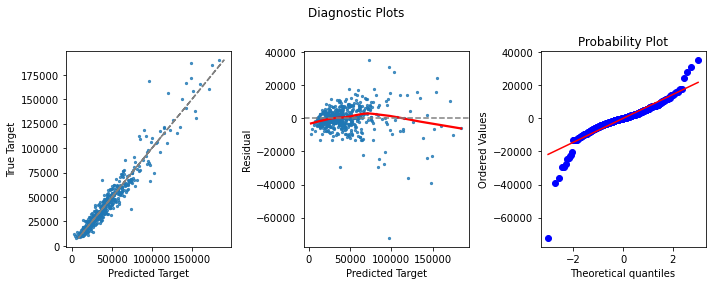

In [18]:
diagnostic_plots(lr.predict(X_train), y_train)

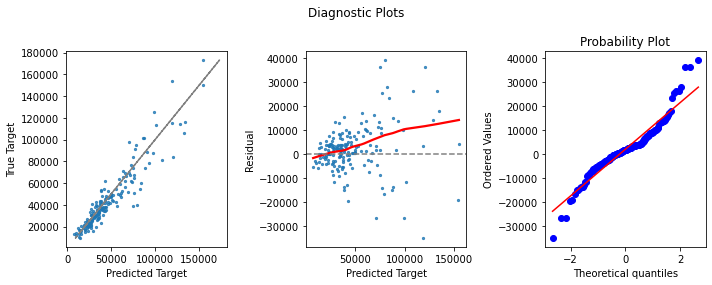

In [19]:
diagnostic_plots(lr.predict(X_val), y_val)

From the histogram, the diagnostic plots make sense because the target variable is heavily right skewed.

<AxesSubplot:>

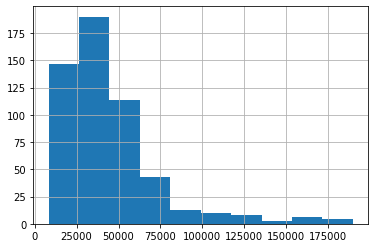

In [20]:
y_train.hist()

# LASSO MODEL

This function will iterate over a range of lambda values to find the lambda value corresponds to the lowest mean absolute error.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



alphalist_l = 10**(np.linspace(-4,4,400))
err_vec_val = np.zeros(len(alphalist_l))
err_vec_train = np.zeros(len(alphalist_l))

for i,curr_alpha in enumerate(alphalist_l):

    # note the use of a sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train.loc[:,:].values, y_train)
    
    val_set_pred = pipe.predict(X_val.loc[:,:].values)
    err_vec_val[i] = mae(y_val, val_set_pred)



/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4840100731.812828, tolerance: 47179620.067649804
  model = cd_fast.enet_coordinate_descent(
/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4636876571.669672, tolerance: 47179620.067649804
  model = cd_fast.enet_coordinate_descent(
/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4437469907.960621, tolerance: 47179620.067649804
  model = cd_fast.enet_coordinate_descent(
/home/stephen/anaconda3/envs/metis/lib/python3

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1134863178.53553, tolerance: 47179620.067649804
  model = cd_fast.enet_coordinate_descent(
/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1059666121.7208138, tolerance: 47179620.067649804
  model = cd_fast.enet_coordinate_descent(
/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 988653566.6008644, tolerance: 47179620.067649804
  model = cd_fast.enet_coordinate_descent(
/home/stephen/anaconda3/envs/metis/lib/python3

/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130298806.83342743, tolerance: 47179620.067649804
  model = cd_fast.enet_coordinate_descent(
/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119758082.20687103, tolerance: 47179620.067649804
  model = cd_fast.enet_coordinate_descent(
/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110033243.7091713, tolerance: 47179620.067649804
  model = cd_fast.enet_coordinate_descent(
/home/stephen/anaconda3/envs/metis/lib/pytho

The chart is the plot of log of the lambda values versus the mean absolute error. The dip is is where the absolute error is the lowest.

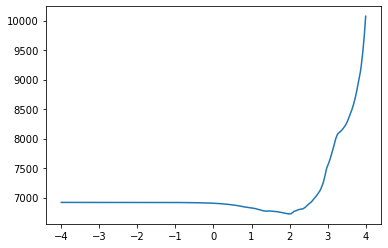

In [22]:
plt.plot(np.log10(alphalist_l), err_vec_val)

This is the minimum error achieved on the validation set across the different alpha values iterated through.

In [23]:
np.min(err_vec_val)

6722.834499917431

This is the value of alpha that gave us the lowest error.

In [24]:
alphalist_l[np.argmin(err_vec_val)]

94.39246843247663

After finding the correct lambda value to use, a lasso model is trained on the training data. The training data needs to be standardize before the lasso model is fit.

In [25]:
std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_tval = std.transform(X_val.values)
X_te = std.transform(X_test.values)
lasso_model = Lasso(alpha = alphalist_l[np.argmin(err_vec_val)])
lasso_model.fit(X_tr,y_train)

Lasso(alpha=94.39246843247663)

This cell make prediction on the standardized training and validation set using the lasso model.

In [26]:
val_set_pred = lasso_model.predict(X_tval)
train_set_pred = lasso_model.predict(X_tr)

This cell calculates the MAE, $R^2_{train}$, $R^2_{val}$ & $R^2_{adjusted}$ for the lasso model

In [27]:

r2 = r2_score(y_val, val_set_pred)
n = len(X_val)
k = len(X_val.columns)

mean_square_error = mae(y_val, val_set_pred)
R2_adj = R_adjusted(r2, n, k)
R2_train = r2_score(y_train, train_set_pred)
R2_val = r2_score(y_val, val_set_pred)

nl = '\n'


print(f'mae:{mean_square_error}{nl}r2_train:{R2_train}{nl}r2_val{R2_val}{nl}r2_adj{R2_adj}')

mae:6722.834499917431
r2_train:0.9259788502221977
r2_val0.8767189089131002
r2_adj0.7372938654219636


In [28]:
coef = list(lasso_model.coef_)
coef = [int(round(x, 0)) for x in coef]
coef_list = list(zip(X_train.columns, coef))

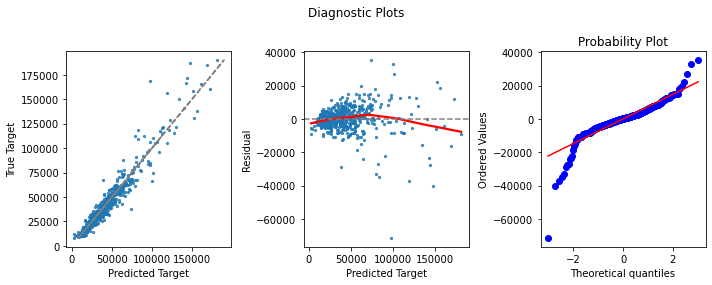

In [29]:
diagnostic_plots(lasso_model.predict(X_tr), y_train)

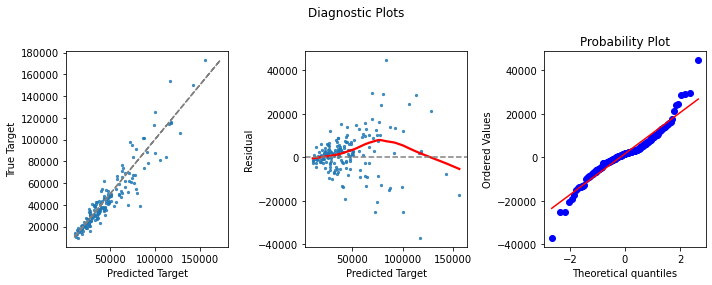

In [30]:
diagnostic_plots(lasso_model.predict(X_tval), y_val)

## Remove Columns

The coeficient list created here comes from the lasso model output. The final column list is all columns were the coeficient did not head to zero in the lasso model.

In [31]:
coef = list(lasso_model.coef_)
coef = [int(round(x, 0)) for x in coef]
coef_list = list(zip(X_train.columns, coef))
keep_list = list(filter(lambda x: x[1] != 0, coef_list))
final_col_list = [x[0] for x in keep_list]
df_coef = pd.DataFrame(keep_list, columns = ('feature', 'coef'))
df_coef.sort_values('coef', ascending=False).head(30)

,feature,coef
1,power,16091
4,torque,8024
6,acceleration,4644
3,engine cap,3555
0,year,3480
28,make_Maserati,3375
27,make_Land,2047
30,make_Mercedes-Benz,1742
35,make_Porsche,1731
21,make_Infiniti,1511


After the final column list is create the train, test, and validation dataframes are parsed down to remove columns that had coeficient that went to zero in the lasso model.

In [32]:
X_train_n = X_train[X_train.columns.intersection(final_col_list)]
X_val_n = X_val[X_val.columns.intersection(final_col_list)]
X_test_n = X_test[X_test.columns.intersection(final_col_list)]
X_train_n.head()

,year,power,cylinders,engine cap,torque,speed,acceleration,stroke,drivetrain_front+rear,drivetrain_rear,...,transmission_6 speed manual transmission,transmission_6 speed semi-automatic,transmission_7 speed automatic with double clutch,transmission_8 speed automatic,transmission_9 speed automatic,transmission_traploze automatic,fuel_bio ethanol / gasoline,fuel_diesel,fuel_lpg / gasoline,fuel_natural gas / gasoline
826,2018,95,3,999,129.06,116,10.8,3.01,0,0,...,0,0,0,0,0,0,0,0,0,0
368,2015,177,4,2143,258.11,142,8.3,3.48,0,0,...,0,0,1,0,0,0,0,1,0,0
558,1989,75,4,1360,80.38,106,11.1,3.03,0,0,...,0,0,0,0,0,0,0,0,0,0
173,2007,130,4,1910,206.49,124,9.5,3.56,0,0,...,1,0,0,0,0,0,0,1,0,0
230,2012,142,4,1798,128.32,131,11.4,3.44,0,0,...,0,0,0,0,0,0,0,0,0,0


These next cells set up a LARS path plot for the data after columns are removed.

In [33]:
from sklearn.linear_model import lars_path
X_lars = np.array(X_train_n)
y_lars = np.array(y_train)

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_lars, y_lars, 
                             method='lasso')

Computing regularization path using the LARS ...


/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 47 iterations, i.e. alpha=4.322e+01, with an active set of 39 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 68 iterations, i.e. alpha=2.125e+01, with an active set of 58 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/home/stephen/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:615: ConvergenceWarning: Regressors in active set degenera

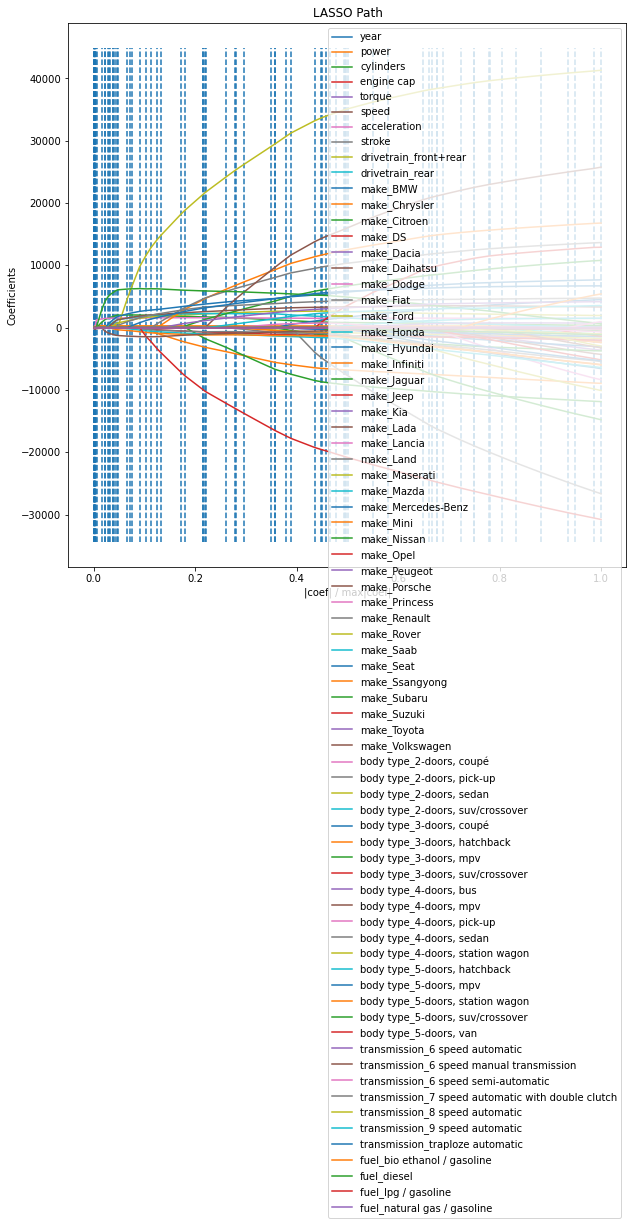

In [54]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]


plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')

plt.legend(final_col_list)

plt.ylim([-1500, 1500])


The scale of this graph was reduced to see the trend of the feature power because of the linear relationship with the target variable.

## New Linear Regression After Column Removal

This linear regression includes all the paired down columns and calculated the MAE, $R^2_{train}$, $R^2_{val}$ & $R^2_{adjusted}$. The adjusted $R^2$ increased because the number of features went from 91 to 25.

In [35]:
lr = LinearRegression()
lr.fit(X_train_n, y_train)

val_set_pred_n = lr.predict(X_val_n)
r2 = lr.score(X_val_n, y_val)
n = len(X_val_n)
k = len(X_train_n.columns)


mean_square_error = mae(y_val, val_set_pred_n)
R2_adj = R_adjusted(r2, n, k)
R2_train = lr.score(X_train_n, y_train)
R2_val = lr.score(X_val_n, y_val)

nl = '\n'

print(f'mae:{mean_square_error}{nl}r2_train:{R2_train}{nl}r2_val{R2_val}{nl}r2_adj{R2_adj}')

mae:6964.92583030786
r2_train:0.9291721739508302
r2_val0.8638134483364023
r2_adj0.7656019928097693


Creates coefficient list for linear regression model output

In [36]:
coef = list(lr.coef_)
coef = [int(round(x, 0)) for x in coef]
coef_list = list(zip(X_train.columns, coef))
coef_list

[('year', 413),
 ('power', 231),
 ('cylinders', 93),
 ('engine cap', 7),
 ('compression', 114),
 ('torque', -217),
 ('speed', 1600),
 ('acceleration', -1900),
 ('bore', 2802),
 ('stroke', 699),
 ('drivetrain_front+rear', 4969),
 ('drivetrain_rear', -9108),
 ('make_BMW', -1693),
 ('make_Chevrolet', -4936),
 ('make_Chrysler', -10554),
 ('make_Citroen', -1393),
 ('make_DS', 2907),
 ('make_Dacia', -3867),
 ('make_Daewoo', -2875),
 ('make_Daihatsu', 24),
 ('make_Dodge', -7650),
 ('make_Fiat', 15578),
 ('make_Ford', 11827),
 ('make_Honda', 1159),
 ('make_Hyundai', -7603),
 ('make_Infiniti', -6780),
 ('make_Jaguar', -2336),
 ('make_Jeep', 15036),
 ('make_Kia', 45627),
 ('make_Lada', -3873),
 ('make_Lancia', 6736),
 ('make_Land', -4137),
 ('make_Lexus', -4879),
 ('make_Maserati', -2708),
 ('make_Mazda', -2483),
 ('make_Mercedes-Benz', 31299),
 ('make_Mini', -12225),
 ('make_Mitsubishi', -1943),
 ('make_Nissan', -6792),
 ('make_Opel', 1083),
 ('make_Peugeot', -4005),
 ('make_Porsche', -13617),


## Ridge Model

This function will iterate over a range of lambda values to find the lambda value corresponds to the lowest mean absolute error for the ridge regression model.

In [101]:
alphalist_r = 10**(np.linspace(-2,10,200))
err_vec_val = np.zeros(len(alphalist_r))
err_vec_train = np.zeros(len(alphalist_r))

for i,curr_alpha in enumerate(alphalist_r):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train_n.values, y_train)
    
    val_set_pred_r = pipe.predict(X_val_n.values)
    err_vec_val[i] = mae(y_val, val_set_pred_r)



The chart is the plot of log of the lambda values versus the mean absolute error. The dip is is where the absolute error is the lowest.

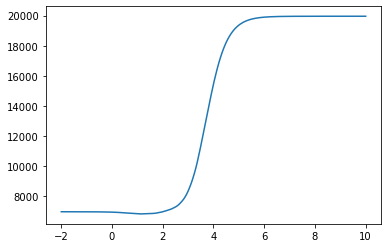

In [102]:
plt.plot(np.log10(alphalist_r), err_vec_val)

This is the minimum error achieved on the validation set across the different alpha values iterated through.

In [103]:
np.min(err_vec_val)

6819.897178593785

This is the value of alpha that gave us the lowest error.

In [104]:
alphalist_r[np.argmin(err_vec_val)]

13.66716356462006

After finding the correct lambda value to use, a lasso model is trained on the training data. The training data needs to be standardize before the ridge model is fit.

In [105]:
std = StandardScaler()
std.fit(X_train_n.values)
X_tr_r= std.transform(X_train_n.values)
X_tval_r= std.transform(X_val_n.values)
X_te_r = std.transform(X_test_n.values)
ridge_model = Ridge(alpha = alphalist_r[np.argmin(err_vec_val)])
ridge_model.fit(X_tr_r,y_train)

Ridge(alpha=13.66716356462006)

This cell make prediction on the standardized training and validation set using the ridge model.

In [106]:
val_set_pred_r = ridge_model.predict(X_tval_r)
train_set_pred_r = ridge_model.predict(X_tr_r)

This cell calculates the MAE, $R^2_{train}$, $R^2_{val}$ & $R^2_{adjusted}$ for the ridge model

In [107]:
r2 = r2_score(y_val, val_set_pred_r)
n = len(X_val_n)
k = len(X_val_n.columns)

mean_square_error = mae(y_val, val_set_pred_r)
R2_adj = R_adjusted(r2, n, k)
R2_train = r2_score(y_train, train_set_pred_r)
R2_val = r2_score(y_val, val_set_pred_r)

nl = '\n'


print(f'mae:{mean_square_error}{nl}r2_train:{R2_train}{nl}r2_val{R2_val}{nl}r2_adj{R2_adj}')

mae:6819.897178593785
r2_train:0.9265905463341265
r2_val0.8734992804690669
r2_adj0.7822728000381055


Creates coefficient list for ridge regression model output

In [108]:
coef = [int(x) for x in  ridge_model.coef_]
coef_list = list(zip(X_train_n.columns, coef))
coef_list
df_coef2 = pd.DataFrame(coef_list, columns = ('feature', 'coef'))
df_coef2.sort_values('coef', ascending=False)

,feature,coef
1,power,12681
4,torque,8908
3,engine cap,4315
6,acceleration,3985
0,year,3732
...,...,...
51,"body type_3-doors, hatchback",-1762
57,"body type_4-doors, sedan",-1983
61,"body type_5-doors, station wagon",-2580
63,"body type_5-doors, van",-2759


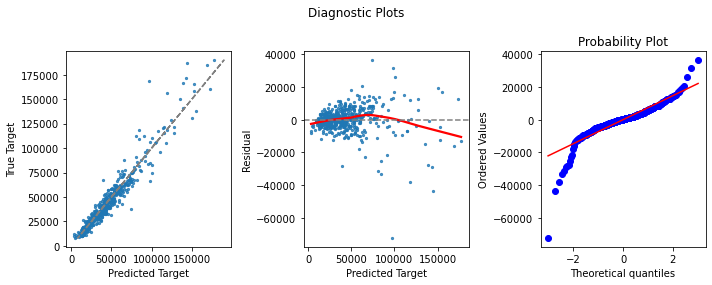

In [109]:
diagnostic_plots(ridge_model.predict(X_tr_r), y_train)

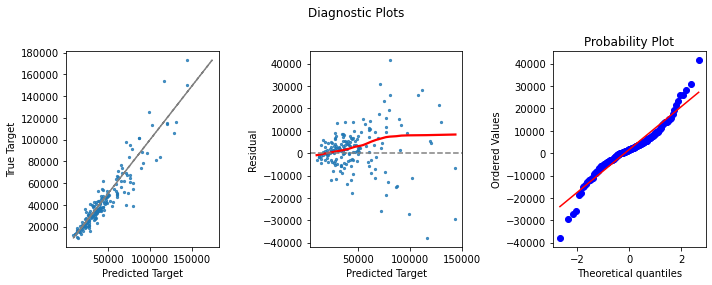

In [110]:
diagnostic_plots(ridge_model.predict(X_tval_r), y_val)

## LASSO Regression Test Data Output

In [47]:
test_set_pred = lasso_model.predict(X_te)

In [48]:
r2 = r2_score(y_test, test_set_pred )
n = len(X_test)
k = len(X_test.columns)

mean_square_error = mae(y_test, test_set_pred)
R2_adj = R_adjusted(r2, n, k)
R2_train = r2_score(y_train, train_set_pred)
R2_val = r2_score(y_val, val_set_pred)
R2_test = r2_score(y_test, test_set_pred)

nl = '\n'


print(f'mae:{mean_square_error}{nl}r2_train:{R2_train}{nl}r2_val{R2_val}{nl}r2_test{R2_test}{nl}r2_adj{R2_adj}')

mae:5535.521352334866
r2_train:0.9259788502221977
r2_val0.8767189089131002
r2_test0.9249629323059096
r2_adj0.8400995819375932


## Linear Regression Test Data Output

In [53]:
test_set_pred_n = lr.predict(X_test_n)
r2 = lr.score(X_test_n, y_test)
n = len(X_test_n)
k = len(X_test_n.columns)


mean_square_error = mae(y_test, test_set_pred_n)
R2_adj = R_adjusted(r2, n, k)
R2_train = lr.score(X_train_n, y_train)
R2_val = lr.score(X_val_n, y_val)
R2_test = r2_score(y_test, test_set_pred_n)

nl = '\n'


print(f'mae:{mean_square_error}{nl}r2_train:{R2_train}{nl}r2_val{R2_val}{nl}r2_test{R2_test}{nl}r2_adj{R2_adj}')

mae:5849.732674142778
r2_train:0.9291721739508302
r2_val0.8638134483364023
r2_test0.9179064301732746
r2_adj0.8587043365482322


## Ridge Test Ridge Data Output

In [111]:
test_set_pred_r = ridge_model.predict(X_te_r)

In [112]:
r2 = r2_score(y_test, test_set_pred_r)
n = len(X_test_n)
k = len(X_test_n.columns)

mean_square_error = mae(y_test, test_set_pred_r)
R2_adj = R_adjusted(r2, n, k)
R2_train = r2_score(y_train, train_set_pred_r)
R2_val = r2_score(y_val, val_set_pred_r)
R2_test = r2_score(y_test, test_set_pred_r)

nl = '\n'


print(f'mae:{mean_square_error}{nl}r2_train:{R2_train}{nl}r2_val{R2_val}{nl}r2_test{R2_test}{nl}r2_adj{R2_adj}')

mae:5534.1686135363725
r2_train:0.9265905463341265
r2_val0.8734992804690669
r2_test0.9263334043251722
r2_adj0.8732084555212098


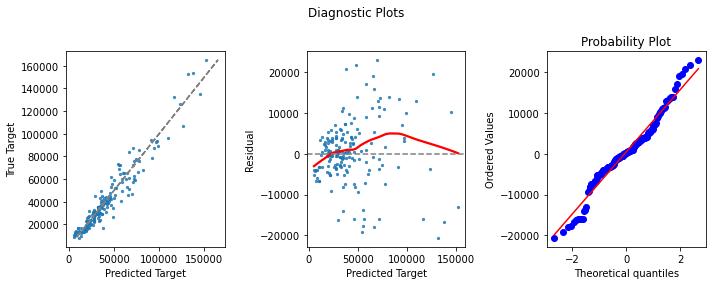

In [51]:
diagnostic_plots(ridge_model.predict(X_te_r), y_test)

This graph shows the predicted car value versus the true car value for the test data.

<Figure size 648x792 with 0 Axes>

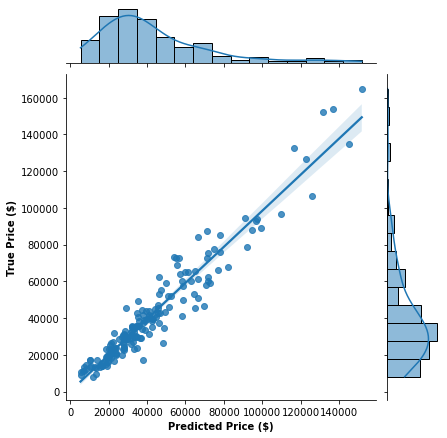

In [100]:
fig = plt.figure(figsize=(9, 11))

preds = ridge_model.predict(X_te_r) # generate predictions (on training data) using fit model

pt = sns.jointplot(x=preds,y=y_test, kind='reg')
pt.ax_joint.set_xlabel('Predicted Price ($)', fontweight='bold')
pt.ax_joint.set_ylabel('True Price ($)', fontweight='bold')
plt.savefig('test_prediction.png',bbox_inches = 'tight')

Here is the linear relationship between price and horsepower

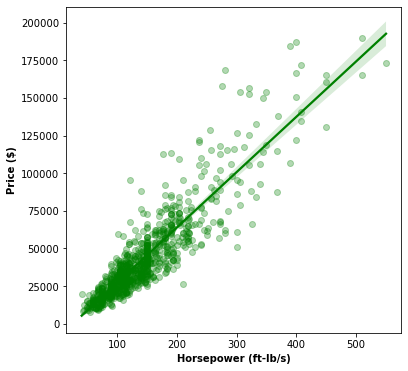

In [99]:
fig = plt.figure(figsize=(6, 6))

x1 = df_clean['power']
y1 = df_clean['price']

pt = sns.regplot(x=x1, y=y1, color='g', scatter_kws={'alpha':0.3})
# pt = sns.scatterplot(x=x1,y=y1)

plt.ylabel("Price ($)", fontweight='bold')
plt.xlabel("Horsepower (ft-lb/s)", fontweight='bold')

plt.savefig('price_vs_hp.png',bbox_inches = 'tight')

These are the true car prices and the predicted car prices with name and year appended for the test set.

In [84]:
s1 = pd.DataFrame(preds)
s1
s2 =  pd.DataFrame(y_test)
s3 = df_clean[['name','year']]
df_pred = s2.merge(s3, left_index = True, right_index = True).reset_index()
df_pred = pd.concat([df_pred, s1], axis=1)
cols = df.columns.tolist()

df_pred.head(30)

,index,price,name,year,0
0,84,39713,BMW 318iS Coupe technical specs,1996,42397.900586
1,690,35088,Renault Megane Estate 2.0 16V 140 Collection t...,2012,42715.245953
2,142,34960,Citroen Evasion 1.9 TD Ligne Seduction technic...,1998,32106.021838
3,796,26980,Volkswagen New Beetle Cabrio 1.4 Turijn Comfor...,2005,32781.865210
4,746,39254,Toyota Avensis Wagon 2.2 D-4D Executive techni...,2006,43310.871077
5,6,35550,Audi A3 1.9 TDI Attraction Pro Line technical ...,2009,35085.079234
6,650,34281,Skoda Octavia Combi 1.9 TDI 130hp Elegance tec...,2003,37172.783079
7,320,57616,Lexus IS 250 Sport technical specs,2009,58553.974702
8,744,30829,Toyota Avensis 1.8 16v VVT-i Linea Sol technic...,2003,31407.091151
9,625,29776,Seat Leon SC 1.4 EcoTSI 150hp FR technical specs,2015,33662.274879
